# A diver operated stereo-video approach for characterizing reef fish spawning aggregations: the Galapagos Marine Reserve as case study

The [pandas](http://pandas.pydata.org/pandas-docs/stable/index.html) package is used for data manipulation
The [rpy2](https://rpy2.github.io/doc/latest/html/index.html) package is used for R data analyses from Python.
The [matplotlib](http://matplotlib.org/) package is used for $2$D data visualization.
Data is available in the `share` directory of this repository:

In [1]:
from pandas import DataFrame, read_csv, np

import rpy2
from rpy2.robjects import r as R, pandas2ri
pandas2ri.activate()
%reload_ext rpy2.ipython

%matplotlib inline
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['svg.fonttype'] = 'none'
from matplotlib import pyplot as plt

import math
import os

C:\Users\pierre.fernique\Miniconda3\envs\RGHAFS20\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## Biomass

In order to fit the allometric relationship between the length and weight, we use the linear model

$$ \log(w_i) = \alpha + \beta \times \log(l_i) + \epsilon_i,$$

where

* $i$ denotes an individual,
* $w_i$ denotes its weight,
* $l_i$ denotes its length,
* $\alpha$ denotes the intercept (theoritical weight of fish of length $0.0$),
* $\beta$ denotes the slope.
* $\epsilon_i$ denotes the Gaussian noise.

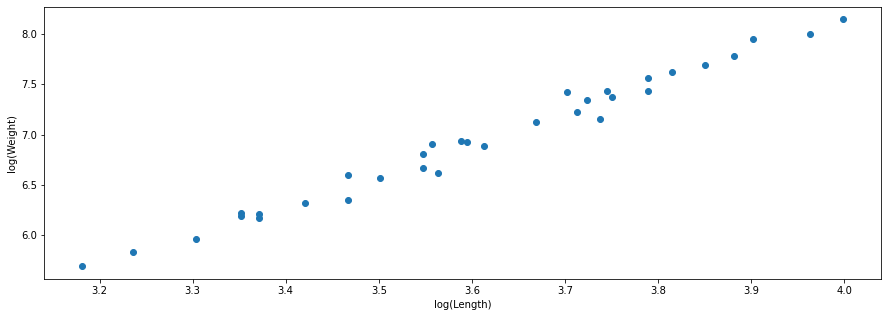

In [2]:
biomass = read_csv(os.path.join('share',
                                'biomass.csv'),
                   sep=',')
R.assign('biomass',
         biomass)
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
logx = True
logy = True
x = biomass.FL
y = biomass.W
if logx:
    x = [math.log(x) for x in x]
if logy:
    y = [math.log(y) for y in y]       
plt.plot(x,y,'o')
_ = axes.set_xlabel('log(Length)')
_ = axes.set_ylabel('log(Weight)')

In [3]:
%%R
reg = lm('log(W) ~ log(FL)',
         data=biomass)
coefficients = summary(reg)$coefficients
prd = predict(reg)
summary(reg)

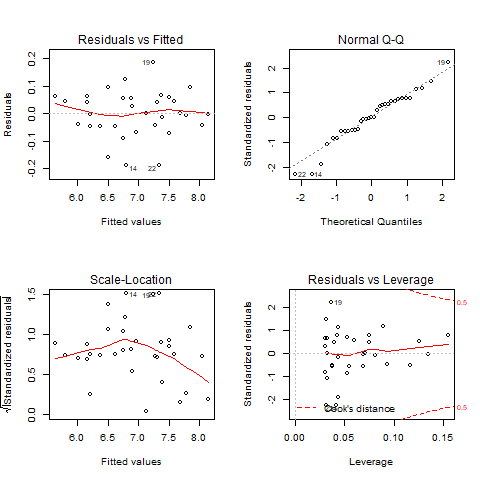

In [4]:
%%R
par(mfrow=c(2,2))
plot(reg)

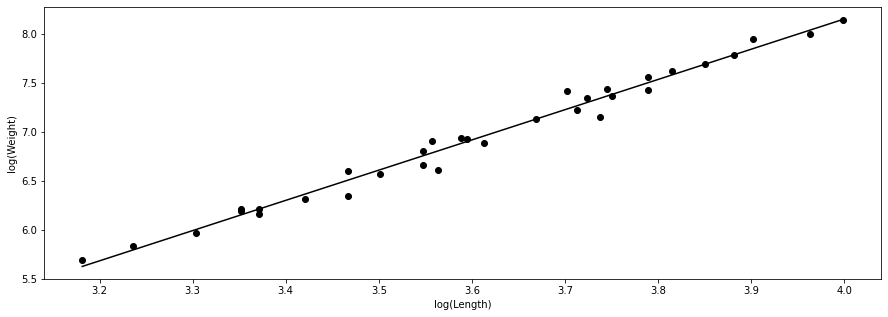

In [5]:
%Rpull prd
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
plt.plot(x,y,'ko')
plt.plot(x,list(prd),'k-')
_ = axes.set_xlabel('log(Length)')
_ = axes.set_ylabel('log(Weight)')
fig.savefig('lW-lL.svg')

## Selecting a site

On this table the results of the linear model are displayed.
In particular:

* $\alpha = -4.19841$ (first column on line (Intercept)) and significantly different from $0.0$ (last column on line (Intercept)),
* $\beta = 3.09$ (first column on line log(FL)) and significantly different from $0.0$ (last column on line log(FL)).

The following plots can be used to verify the validity of linear model underlying hypotheses.
In particular:

* The top-left graph enable the verification of the homoscedasticity.
* The top-right graph enable the verification of the normality of errors.

And the graphic below illustrate the adjustment of the linear model (red line) to the data (blue dots). 

We are now interested into converting randomly collected lengths in the video (see graph below) into weights using the previous length-weight allometric relationship.

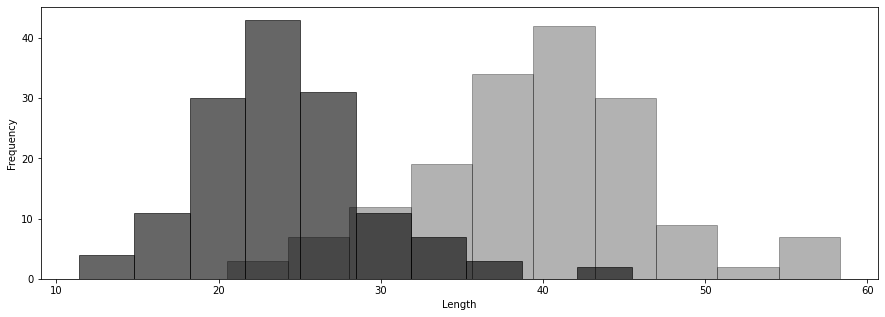

In [6]:
lengths = read_csv(os.path.join('share',
                                'lengths.csv'),
                   sep=',')
R.assign('lengths',
         lengths)
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
for sex, color in zip(['M', 'F'], [.3, .6]):
    axes.hist(lengths.Length[lengths.Stage == sex].tolist(),
              alpha=color,
              edgecolor='k',
              color='k')
_ = axes.set_xlabel('Length')
_ = axes.set_ylabel('Frequency')
fig.savefig('length.svg')

On this graph are displayed the histograms of lengths for:

* females, in dark gray,
* males, in light gray.

In order to test if the sex has an influence on the length, we use the linear model

$$ l_i = \alpha_{s_i} + \epsilon_i,$$

where

*   $i$ denotes an individual.
*   $l_i$ is its length.
*   $\alpha_{s_i}$ is a coefficient depending on the sex of the individual.
    There two different coefficients : $\alpha_{F}$ for females and $\alpha_M$ for males.
*   $\epsilon_i$ is the Gaussian noise.

In [7]:
%%R
reg = lm('Length ~ Stage', data=lengths)
summary(reg)

On this table are displayed the estimated average length of:

* females, $\alpha_F = 24.14$ (first column on line (Intercept)) and significantly different from $0$ (last column on line (Intercept)),
* males, $\alpha_M = 24.14+15.65=39.79$ (first column on line (Intercept) plus the first column on line StageM) and significantly different from  the average of females (last column on line StageM).

The following plots can be used to verify the validity of linear model underlying hypotheses.
In particular:

* The top-left graph enable the verification of the homoscedasticity.
* The top-right graph enable the verification of the normality of errors.

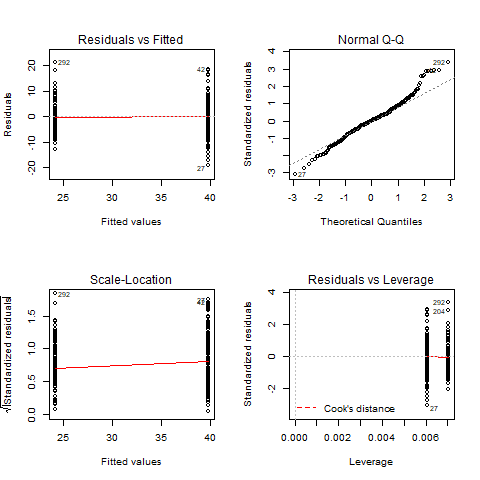

In [8]:
%%R
par(mfrow=c(2,2))
plot(reg)

Using the allometric relationships we display below the histogram of weights conditionally to the sex:

* In light gray the histogram of male weights.
* In dark gray the histogram of female weights.

C:\Users\pierre.fernique\Miniconda3\envs\RGHAFS20\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


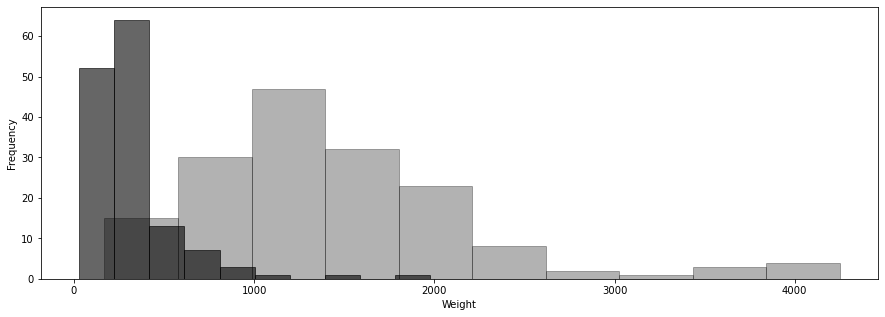

In [9]:
%Rpull coefficients
coefficients = np.array(coefficients)
alpha = math.exp(coefficients[0,0])
beta = coefficients[1,0]
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
for sex, color in zip(['M', 'F'], [.3, .6]):
    axes.hist([alpha * length**beta for length in lengths.Length[lengths.Stage == sex].tolist()],
              alpha=color,
              color='k',
              edgecolor='k')
axes.set_xlabel('Weight')
axes.set_ylabel('Frequency')
fig.savefig('weight.svg')

## Describing the reproductive behaviour of the species based on tangible quantitative data and explicit 3D representation of the spawning event.

### Preamble

Using [VTK](http://www.vtk.org/) to visualize frames.

In [10]:
from RGHAFS20.frame import vtk

To ease the *VTK* interactions we provide $3$ functions

* `renderers`, initialize differnt views of the same frame (e.g. one for viewing only males and one for viewing only females)
* `synchornize`, allow different views of the same frame (see above) to share the same camera in order to ease comparisons (when the camera of a view is moved, the other views moves in the same manner).
* `show`, is just an aggregation of *VTK* commands to display the frame and convert the selected view into a PNG image embedded in the notebook using [matplotlib](http://matplotlib.org/1.4.0/index.html) (if a name is provided, the image is written on the disk with the given name).

In [11]:
from RGHAFS20.frame import renderers, synchronize, show

A frame is represented by a set of $3$D points (columns **X**, **Y** and **Z**) associated to an indentifier (**Type**).
The identifier used are :

* G, for ground.
* M, for bodanius males.
* F, for bodanius females.

In [12]:
id_frame = 2
frame = read_csv(os.path.join('share',
                              'frame_'+str(id_frame)+'/points.csv'),
                 sep='\t')
frame

,Unnamed: 0,Type,Precision,RMS,Range,Direction,X,Y,Z
0,19,M,18841,3609,6946071,22366,-2495922,768215,-6436468
1,20,M,17684,121,6694072,20331,-2189589,684936,-6288653
2,21,M,10987,17919,5357418,12336,193847,-1210530,-5215263
3,22,M,14547,6941,6239373,9509,-988059,196378,-6157512
4,23,M,20899,1983,7628989,5484,-720332,-232559,-7591345
...,...,...,...,...,...,...,...,...,...
134,153,G,25617,6331,8696359,4312,523340,255068,-8676849
135,154,G,24864,5062,8347051,5047,-705588,-334458,-8310448
136,155,G,21552,3869,7769343,4464,-515518,-438376,-7739816
137,156,G,16906,9679,6634123,16174,1308985,-1404846,-6350162


On each frame, bodanius are are represented by spheres

In [13]:
from RGHAFS20.frame import plot_spheres

window = vtk.vtkRenderWindow()
renderer = renderers(window, 1,1).pop()

plot_spheres(frame[frame.Type != 'G'], renderer, 0., 1., 0., size=200000)

show(window)
del window

AttributeError: 'vtkIOImagePython.vtkPNGWriter' object has no attribute 'SetInput'

On each frame the ground is represented by a surface representing the delaunay triangulation of avaible points.

In [14]:
from RGHAFS20.frame import plot_delaunay_2D

window = vtk.vtkRenderWindow()
renderer = renderers(window, 1,1).pop()

plot_delaunay_2D(frame[frame.Type == 'G'], renderer, 1., 1., 0.)

show(window)
del window

AttributeError: 'vtkIOImagePython.vtkPNGWriter' object has no attribute 'SetInput'

The resulting frame is a combination of:

* A yellow surface representing the ground.
* Blue spheres representing male bodanius.
* Red spheres representing female bodanius.

In [15]:
id_frame = 4
frame = read_csv(os.path.join('share',
                              'frame_' + str(id_frame) + '/points.csv'),
                 sep='\t')

window = vtk.vtkRenderWindow()
renderer = renderers(window, 1,1).pop()

plot_spheres(frame[frame.Type == 'M'], renderer, 0., 0., 1., size=200000)
plot_spheres(frame[frame.Type == 'F'], renderer, 1., 0., 0., size=200000)
plot_delaunay_2D(frame[frame.Type == 'G'], renderer, 1., 1., 0.)

show(window, magnification=5, name='./frame.svg')
del window

AttributeError: 'vtkIOImagePython.vtkPNGWriter' object has no attribute 'SetInput'

### Distances between individuals

Since the units of positions are in micrometers, one use the `SI` function to convert them into meters.

In [16]:
from wanda.tools import SI

ModuleNotFoundError: No module named 'wanda'

In order to compare behaviours of males and females we consider sex minimal intra and inter-distances.
The minimal intra-distance is the minimal distance of one individual to another individual of the same sex.
*A contrario*, the minimal inter-distance is the minimal distance of one individual to another individual of the other sex.
These distances are displayed using conditional histograms for males (in blue) and females (in red) and statistically compared using:

* [Wilcoxon rank sum test](http://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test),
* Gamma [GLMs](http://en.wikipedia.org/wiki/Generalized_linear_model), 
* Model selection using the `step` function and the Bayesian Information Criterion ([BIC](http://en.wikipedia.org/wiki/Bayesian_information_criterion)).

The Wilcoxon rank sum test and Gamma GLMs are used since the obersations are clearly non-normal.

#### Intra-distances

In [ ]:
from wanda.distances import intra
frames = []
for id_frame in range(1,20):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    for sex in ['F', 'M']:
        if id_frame < 16:
            X, Y, Z = SI(frame[frame.Type == sex], 'micro')
        else:
            X, Y, Z = SI(frame[frame.Type == sex], 'mm')
        for d in intra(X, Y, Z):
            frames.append([d, sex])
frames = DataFrame(data=frames, columns=['d', 'sex'])
%Rpush frames
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
histM = axes.hist(frames[frames.sex == 'M'].d.tolist(), alpha=.5, color='b', normed=True)
histF = axes.hist(frames[frames.sex == 'F'].d.tolist(), alpha=.5, color='r', normed=True)

In [ ]:
%%R
wilcox.test(d ~ sex, data=frames)

In [ ]:
%%R
reg = glm(d~sex,family=Gamma, data=frames)
summary(reg)

In [ ]:
%%R
attributes(reg)

In [ ]:
%%R
step(reg, k = log(reg$n))

The three approaches (Test, GLMs+Test and Model selection) are considering that intra-distances within females and within males are significatively different.
Males tend to be less close than females.

#### Inter-distances

Inter-distances are not really relevant and are not significatively different.
The approach below comparing intra-distances to inter-distances seems to be more relevant.

In [ ]:
from wanda.distances import inter
frames = []
for id_frame in range(1,20):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    for sex in ['F', 'M']:
        if id_frame < 16:
            X0, Y0, Z0 = SI(frame[frame.Type == sex], 'micro')
            X1, Y1, Z1 = SI(frame[frame.Type == 'G'], 'micro')
        else:
            X0, Y0, Z0 = SI(frame[frame.Type == sex], 'mm')
            X1, Y1, Z1 = SI(frame[frame.Type == 'G'], 'mm')
        for d in inter(X0, Y0, Z0, X1, Y1, Z1):
            frames.append([d, sex])
frames = DataFrame(data=frames, columns=['d', 'sex'])
%Rpush frames
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
histM = axes.hist(frames[frames.sex == 'M'].d.tolist(), alpha=.5, color='b', normed=True)
histF = axes.hist(frames[frames.sex == 'F'].d.tolist(), alpha=.5, color='r', normed=True)

In [ ]:
%%R
wilcox.test(d ~ sex, data=frames)

In [ ]:
%%R
reg = glm(d~sex,family=Gamma, data=frames)
summary(reg)

In [ ]:
%%R
step(reg, k = log(reg$n))

In [ ]:
%%R
par(mfrow=c(2,2))
plot(reg)

#### Comparison of inter and intra-distances

We compare hereabove the intra and inter-distances for males and females.
For both, after a statistical analysis it appears that males are closest to females than to males and vice-versa.

In [ ]:
frames = []
for id_frame in range(1,20):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    if id_frame < 16:
        X0, Y0, Z0 = SI(frame[frame.Type == 'M'], 'micro')
        X1, Y1, Z1 = SI(frame[frame.Type == 'F'], 'micro')
    else:
        X0, Y0, Z0 = SI(frame[frame.Type == 'M'], 'mm')
        X1, Y1, Z1 = SI(frame[frame.Type == 'F'], 'mm')  
    for d in inter(X0, Y0, Z0, X1, Y1, Z1):
        frames.append([d, 'F'])
    for d in intra(X0, Y0, Z0):
        frames.append([d, 'M'])
frames = DataFrame(data=frames, columns=['d', 'sex'])
%Rpush frames
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
histM = axes.hist(frames[frames.sex == 'M'].d.tolist(), alpha=.5, color='b', normed=True)
histF = axes.hist(frames[frames.sex == 'F'].d.tolist(), alpha=.5, color='r', normed=True)

In [ ]:
%%R
wilcox.test(d ~ sex, data=frames)

In [ ]:
%%R
reg = glm(d~sex,family=Gamma, data=frames)
summary(reg)

In [ ]:
%%R
step(reg, k = log(reg$n))

In [ ]:
%%R
par(mfrow=c(2,2))
plot(reg)

In [ ]:
frames = []
for id_frame in range(1,20):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    if id_frame < 16:
        X0, Y0, Z0 = SI(frame[frame.Type == 'F'], 'micro')
        X1, Y1, Z1 = SI(frame[frame.Type == 'M'], 'micro')
    else:
        X0, Y0, Z0 = SI(frame[frame.Type == 'F'], 'mm')
        X1, Y1, Z1 = SI(frame[frame.Type == 'M'], 'mm')
    for d in inter(X0, Y0, Z0, X1, Y1, Z1):
        frames.append([d, 'M'])
    for d in intra(X0, Y0, Z0):
        frames.append([d, 'F'])
frames = DataFrame(data=frames, columns=['d', 'sex'])
%Rpush frames
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
histM = axes.hist(frames[frames.sex == 'M'].d.tolist(), alpha=.5, color='b', normed=True)
histF = axes.hist(frames[frames.sex == 'F'].d.tolist(), alpha=.5, color='r', normed=True)

In [ ]:
%%R
aggregate(frames, list(Sex = frames$sex), summary)

In [ ]:
%%R
wilcox.test(d ~ sex, data=frames)

In [ ]:
%%R
reg = glm(d~sex,family=Gamma, data=frames)
summary(reg)

In [ ]:
%%R
step(reg, k = log(reg$n))

## Providing estimates of abundance and volumetric density of fish using individual 3D coordinates

Using convex hulls we are able to estimate the density of a set of fish.

In [ ]:
from wanda.concentration import convex_hull_concentration
frames = []
for id_frame in range(1,13):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    for sex in ['F', 'M']:
        X, Y, Z = SI(frame[frame.Type == sex], 'micro')
        c = convex_hull_concentration(X, Y, Z, nmin=3)
        frames.append([c, sex])
frames = DataFrame(data=frames, columns=['c', 'sex'])
%Rpush frames
frames.dropna(0, 'any')

Given the number of frames the data is limited.
Nevertheless males and females could be compared using Wilcoxon rank sum test for instances.

In [ ]:
%%R
wilcox.test(c ~ sex, data=frames)

But this approach is not entirely satisfying since one compare densities between different frames.
Fish groups are therefore have not the same size and it could be relevant only if fishes are uniformly distributed into their convex hull.
In order to investigate this property we considered the density as a function of the distance of the barycenter of fish groups.
As illustrated on the below (log of density as function of the log distance to the barycenter) the fishes are clearly not uniformly distributed into their convex-hulls.

In [ ]:
from wanda.concentration import radiuses
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
logx = True
logy = True
frames = []
for id_frame in range(1,13):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    for sex, color in zip(['F', 'M'], ['ko', 'kD']):
        X, Y, Z = SI(frame[frame.Type == sex], 'micro')
        r = radiuses(X, Y, Z)
        c = [convex_hull_concentration(X, Y, Z, i, nmin=7) for i in r]
        if logx:
            r = [math.log(r) for r in r]
        if logy:
            c = [math.log(c) for c in c]
        plt.plot(r,c,color, markersize=10., alpha=.3+.3*(sex=='M'))
        for r, c in zip(r, c):
            frames.append([r, c, sex])
axes.set_xlabel('Distance to the barycenter')
axes.set_ylabel('Concentration')
frames = DataFrame(data=frames, columns=['r', 'c', 'sex'])
fig.savefig('density.svg')
%Rpush frames

In fact, it seems that for a group $i$ of individuals of same sex $s_i$: 

$$ \log(d_i) = \alpha_{s_i} + \beta_{s_i} \times r_i + \epsilon_i$$

where:

* $d_i$ is the density of the group,
* $r_i$ is the maximal distance to the barycenter encountered in the group $i$,
* $\epsilon_i$

In [ ]:
%%R
reg = lm('c ~ r * sex', data=frames)
summary(reg)

In [ ]:
%%R
step(reg)

When fitting the linear model to data, both test and model selection approaches propose to consider the following model (the slope is not depending on the sex) :

$$ \log(d_i) = \alpha_{s_i} + \beta \times r_i + \epsilon_i$$

This is particularly interesting since the difference between males and females is therefore only concerning the intercept.
Then

$$\forall r \in \mathbb{R}^+, \quad \frac{d_M}{d_F} = \exp(\alpha_{M}-\alpha_{F}) $$

can be used to compare densities.

In [ ]:
%%R
reg = lm('c ~ r + sex', data=frames)
coefficients = summary(reg)$coefficients
prd = predict(reg, na.action = na.exclude)
summary(reg)

From this table we have $\alpha_M - \alpha_F = -0.68714$.
For a same radius of an enclosing circle, the density of females is therefore $\frac{1}{\exp(-0.68714)} \approx \frac{1}{.50} \approx 2.$ times higher that the one of males.

In [ ]:
newframes = DataFrame(data=[[-.5, 'M'], [3.5, "M"]], columns=['r', 'sex'])
newframes
%Rpush newframes

In [ ]:
%%R
Mpred = predict(reg, newframes)

In [ ]:
newframes = DataFrame(data=[[-.5, 'F'], [3.5, "F"]], columns=['r', 'sex'])
newframes
%Rpush newframes

In [ ]:
%%R
Fpred = predict(reg, newframes)

In [ ]:
%Rpull Fpred
list(Fpred)

In [ ]:
%Rpull Mpred
%Rpull Fpred
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
axes.plot(frames.r[frames.sex == 'F'], frames.c[frames.sex == 'F'], 'ko', markersize=10., alpha=.3)
axes.plot(frames.r[frames.sex == 'M'], frames.c[frames.sex == 'M'], 'kD', markersize=10., alpha=.6)
axes.plot([-.5, 3.5], list(Fpred), 'k:')
axes.plot([-.5, 3.5], list(Mpred), 'k--')
axes.set_xlabel('Distance to the barycenter')
axes.set_ylabel('Concentration')
fig.savefig('density.svg')